# Import the essentials

In [6]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
from torch.optim import lr_scheduler
import os
import argparse
import seaborn as sns
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
from tqdm import tqdm_notebook
import seaborn as sns
import warnings

# Loading Data + EDA

In [7]:
train_csv = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

test_csv = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')

In [8]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [9]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


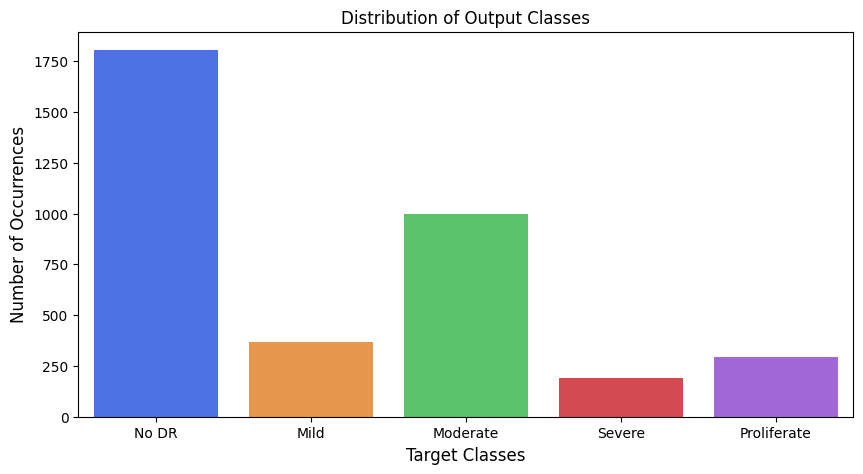

In [10]:
import matplotlib.pyplot as plt

import seaborn as sns



counts = train_csv['diagnosis'].value_counts()

class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']



for i, x in enumerate(class_list):

    counts[x] = counts.pop(i)



plt.figure(figsize=(10, 5))

sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')

plt.title('Distribution of Output Classes')

plt.xlabel('Target Classes', fontsize=12)

plt.ylabel('Number of Occurrences', fontsize=12)

plt.show()

# Visualizing Training Data

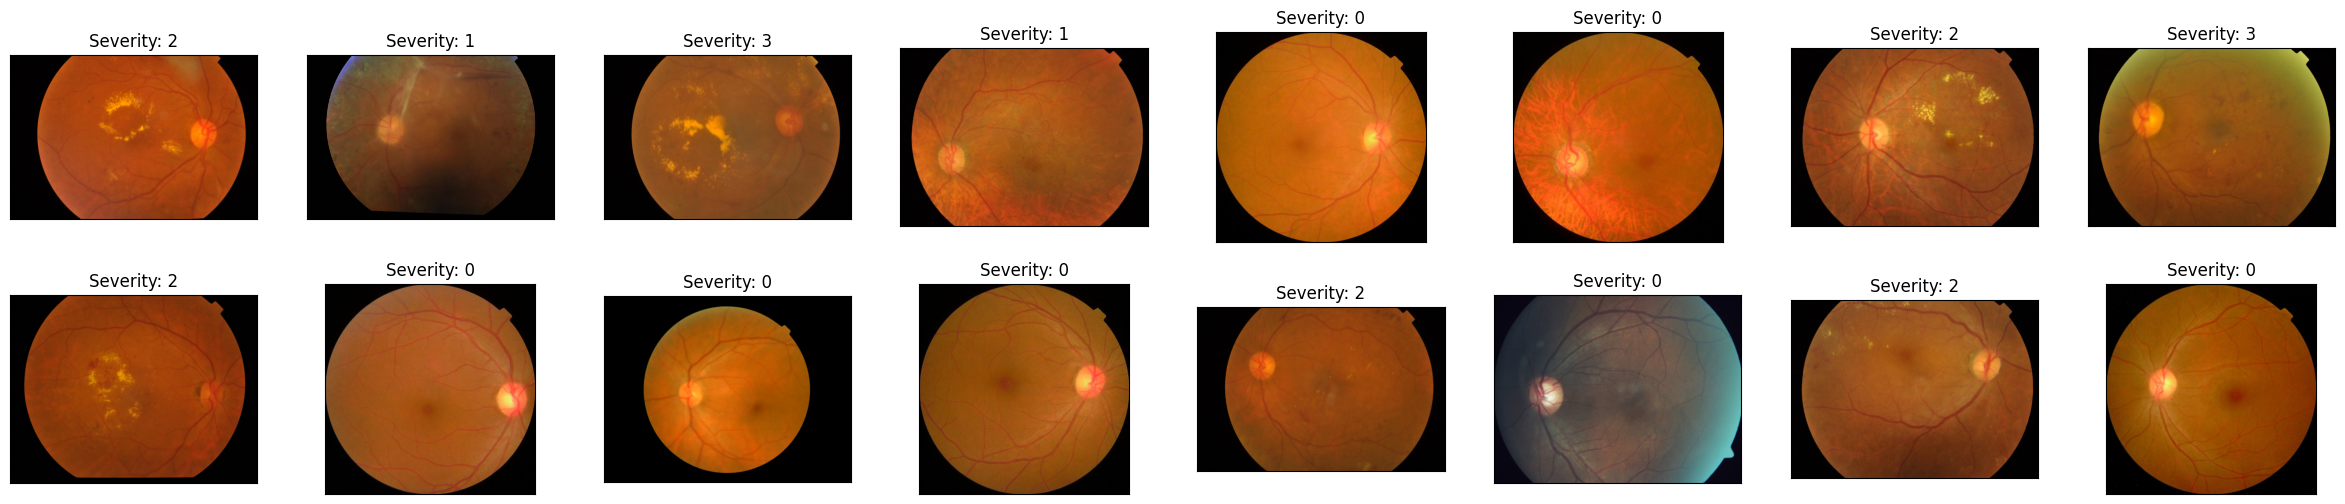

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define base directory

base_dir = '/kaggle/input/aptos2019-blindness-detection'
# List of image files in the training images folder

train_imgs = os.listdir(os.path.join(base_dir, 'train_images'))



# Plotting images
fig = plt.figure(figsize=(30, 6))
# Display 16 random images
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16 // 2, idx + 1, xticks=[], yticks=[])
    im = Image.open(os.path.join(base_dir, "train_images", img))
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s' % lab)

plt.show()

# Visualizing Test Data


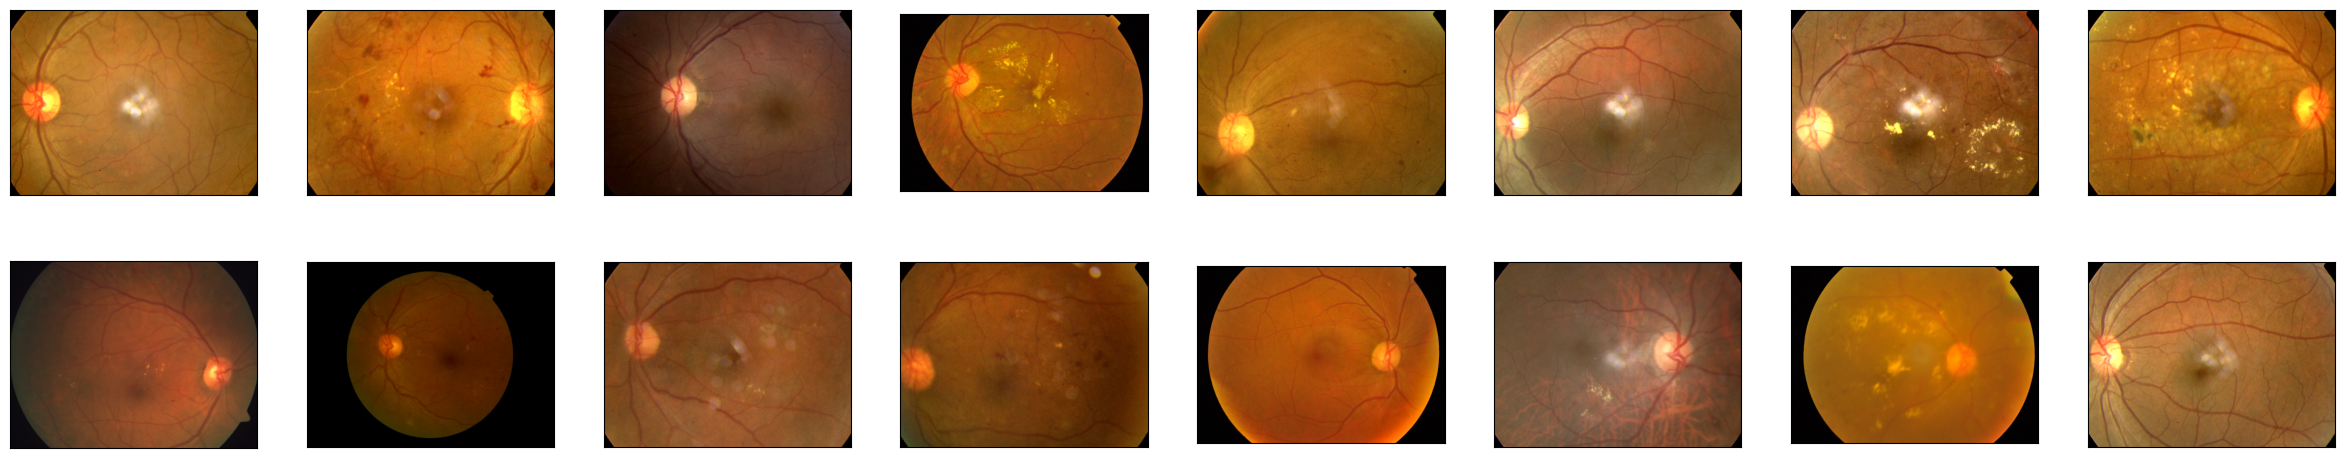

In [12]:
fig = plt.figure(figsize=(30, 6))

# display 20 images

test_imgs = os.listdir(base_dir+"/test_images")

for idx, img in enumerate(np.random.choice(test_imgs, 16)):

    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])

    im = Image.open(base_dir+"/test_images/" + img)

    plt.imshow(im)

# Data Pre Processing

In [13]:
class CreateDataset(Dataset):

    def __init__(self, df_data, data_dir = '../input/', transform=None):

        super().__init__()

        self.df = df_data.values

        self.data_dir = data_dir

        self.transform = transform



    def __len__(self):

        return len(self.df)



    def __getitem__(self, index):

        img_name,label = self.df[index]

        img_path = os.path.join(self.data_dir, img_name+'.png')

        image = cv2.imread(img_path)

        if self.transform is not None:

            image = self.transform(image)

        return image, label

In [14]:
train_transforms = transforms.Compose([

    transforms.ToPILImage(),

    transforms.Resize((256, 256)),

    transforms.RandomHorizontalFlip(p=0.4),

    transforms.ToTensor(),

    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

])

In [15]:
test_transforms = transforms.Compose([transforms.Resize(256),

                                      transforms.CenterCrop(224),

                                      transforms.ToTensor(),

                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [16]:
train_path = "/kaggle/input/aptos2019-blindness-detection/train_images"

test_path = "/kaggle/input/aptos2019-blindness-detection/test_images"

In [17]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)

test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [18]:
valid_size = 0.2

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

In [19]:
train_sampler = SubsetRandomSampler(train_idx)

valid_sampler = SubsetRandomSampler(valid_idx)

In [20]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)

validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)

testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [21]:
print(f"training examples contain : {len(train_data)}")

print(f"testing examples contain : {len(test_data)}")

training examples contain : 3662
testing examples contain : 1928


In [22]:
images, labels = next(iter(trainloader))

# Checking shape of image

print(f"Image shape : {images.shape}")

print(f"Label shape : {labels.shape}")



# denormalizing images for printing as they are in tensors

def imshow(inp, title=None):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])

    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    if title is not None:

        plt.title(title)

    plt.pause(0.001)

Image shape : torch.Size([64, 3, 256, 256])
Label shape : torch.Size([64])


labels: tensor([0, 4, 0, 3, 1, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 1, 4, 0, 4, 1, 0, 0, 2, 0,
        4, 4, 0, 3, 2, 0, 2, 0, 0, 2, 0, 4, 0, 2, 0, 2, 0, 4, 0, 0, 1, 0, 0, 2,
        0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 4])


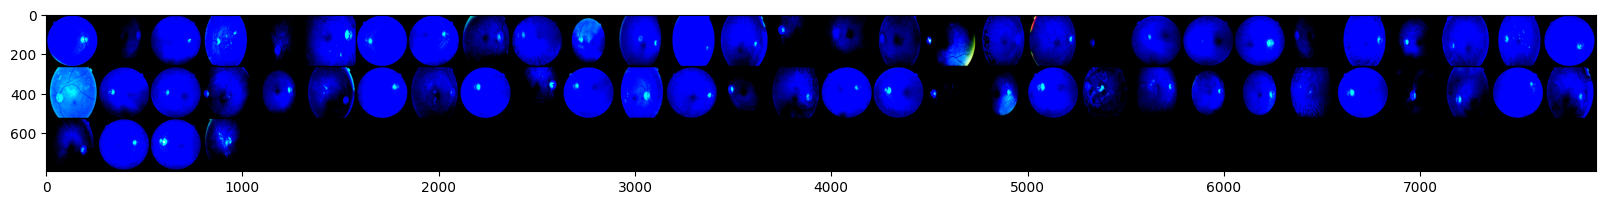

In [23]:
# plotting the images of loaded batch with given fig size and frame data

import torchvision

import matplotlib.pyplot as plt

import numpy as np

grid = torchvision.utils.make_grid(images, nrow=30, padding=7)

# Move the tensor to CPU before transposing

grid = grid.cpu()

plt.figure(figsize=(20, 20))

plt.imshow(np.transpose(grid, (1, 2, 0)))

print('labels:', labels)

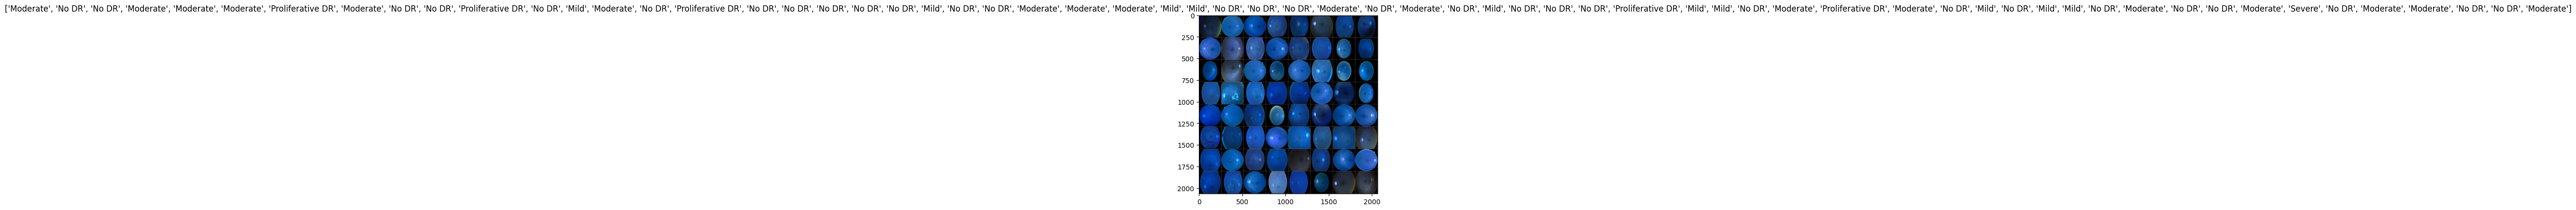

In [24]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']



images, labels = next(iter(trainloader))

out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

In [25]:
###SHUTIL####



import os

import shutil

import random



# Set the directory paths

train = '/kaggle/input/aptos2019-blindness-detection/train_images'

test = '/kaggle/input/aptos2019-blindness-detection/test_images'

# Create the validation directory if it doesn't exist

os.makedirs('test' , exist_ok=True)

os.makedirs('train' , exist_ok=True)

os.makedirs('val' , exist_ok=True)



t_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')



train_df = t_df.sample(frac = 0.80)

test_df = t_df.drop(train_df.index)

test_df.reset_index(drop=True, inplace=True)



val_df = test_df.sample(frac = 0.45)

test_df = test_df.drop(val_df.index)

test_df.reset_index(drop=True, inplace=True)

val_df.reset_index(drop=True, inplace=True)



train_df.sort_values(by='diagnosis', inplace=True)

train_df.reset_index(drop=True, inplace=True)



test_df.sort_values(by='diagnosis', inplace=True)

test_df.reset_index(drop=True, inplace=True)



val_df.sort_values(by='diagnosis', inplace=True)

val_df.reset_index(drop=True, inplace=True)

<Axes: ylabel='count'>

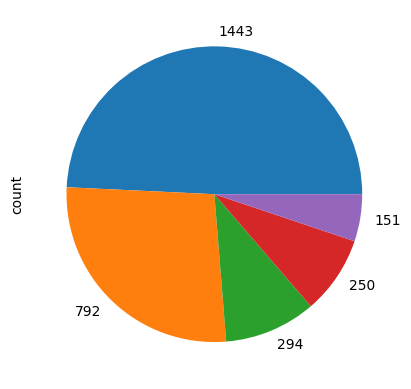

In [26]:
train_df['diagnosis'].value_counts().plot(kind='pie' , labels = list(train_df['diagnosis'].value_counts()))

<Axes: ylabel='count'>

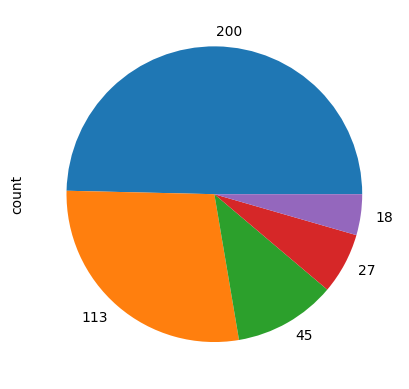

In [27]:
test_df['diagnosis'].value_counts().plot(kind='pie' , labels = list(test_df['diagnosis'].value_counts()))

<Axes: ylabel='count'>

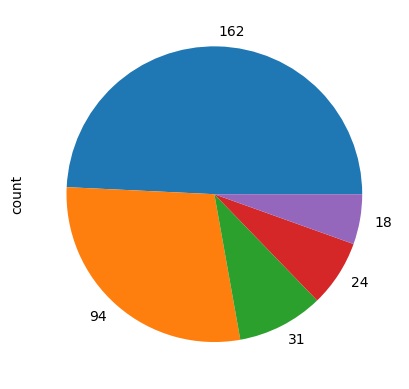

In [28]:
val_df['diagnosis'].value_counts().plot(kind='pie' , labels = list(val_df['diagnosis'].value_counts()))

In [29]:
for i in range(5):

  imgs = train_df[train_df['diagnosis'] == i]['id_code'].to_list()

  os.makedirs(os.path.join('train', str(i)), exist_ok=True)

  for j in imgs:

    shutil.copy(os.path.join(train, j+'.png'), os.path.join(f'train/{i}', str(j)+'.png'))

In [30]:
for i in range(5):

  imgs = test_df[test_df['diagnosis'] == i]['id_code'].to_list()

  os.makedirs(os.path.join('test', str(i)), exist_ok=True)

  for j in imgs:

    shutil.copy(os.path.join(train, j+'.png'), os.path.join(f'test/{i}', str(j)+'.png'))

In [31]:
for i in range(5):

  imgs = val_df[val_df['diagnosis'] == i]['id_code'].to_list()

  os.makedirs(os.path.join('val', str(i)), exist_ok=True)

  for j in imgs:

    shutil.copy(os.path.join(train, j+'.png'), os.path.join(f'val/{i}', str(j)+'.png'))

In [32]:
import os
directory_path = "/kaggle/working/test"
# Get the list of directories inside the specified directory
elements = os.listdir(directory_path)
print(f"Number of elements in each directory inside '{directory_path}':")
for element in elements:
    full_path = os.path.join(directory_path, element)
    if os.path.isdir(full_path):  # Check if the element is a directory
        num_elements = len(os.listdir(full_path))
        print(f"Directory: {element}, Number of elements: {num_elements}")

Number of elements in each directory inside '/kaggle/working/test':
Directory: 0, Number of elements: 200
Directory: 2, Number of elements: 113
Directory: 1, Number of elements: 45
Directory: 4, Number of elements: 27
Directory: 3, Number of elements: 18


In [33]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score

# Define number of classes
num_classes = 5

# Load and modify ResNet50
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
state_dict = torch.load('/kaggle/input/resnet50/pytorch/default/1/best_model-2.pth')
state_dict['fc.weight'] = state_dict.pop('last_linear.weight')
state_dict['fc.bias'] = state_dict.pop('last_linear.bias')
resnet50.load_state_dict(state_dict)
resnet50.eval()

# Load and modify DenseNet201
densenet201 = models.densenet201(pretrained=False)
densenet201.classifier = nn.Linear(densenet201.classifier.in_features, num_classes)
densenet201.load_state_dict(torch.load('/kaggle/input/densenet201/pytorch/default/1/DenseNet201_Best_model.pth'))
densenet201.eval()

# Load and modify DenseNet121 (instead of MobileNetV2)
densenet121 = models.densenet121(pretrained=False)
# Modify classifier layer to handle the mismatch
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, num_classes)

# Load the model state dict
state_dict_densenet121 = torch.load('/kaggle/input/densenet121j/pytorch/default/1/best_model (1)densenet121.pth')

# Since the classifier layers have different names, we'll rename them in the state_dict
# Rename 'classifier.1.weight' and 'classifier.1.bias' to 'classifier.weight' and 'classifier.bias'
state_dict_densenet121['classifier.weight'] = state_dict_densenet121.pop('classifier.1.weight')
state_dict_densenet121['classifier.bias'] = state_dict_densenet121.pop('classifier.1.bias')

# Load the adjusted state dict into the model
densenet121.load_state_dict(state_dict_densenet121)
densenet121.eval()

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50.to(device)
densenet201.to(device)
densenet121.to(device)

# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure compatible input size for all models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the test dataset
test_dir = '/kaggle/working/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation function
def evaluate_model(model, test_loader, device):
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Count correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return all_preds, all_labels, accuracy

# Perform evaluation for each model and collect predictions for ensemble
all_preds_resnet50 = []
all_preds_densenet201 = []
all_preds_densenet121 = []
all_labels = []

# Get predictions for all models
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    # ResNet50 predictions
    outputs_resnet50 = resnet50(images)
    _, predicted_resnet50 = torch.max(outputs_resnet50, 1)
    
    # DenseNet201 predictions
    outputs_densenet201 = densenet201(images)
    _, predicted_densenet201 = torch.max(outputs_densenet201, 1)
    
    # DenseNet121 predictions
    outputs_densenet121 = densenet121(images)
    _, predicted_densenet121 = torch.max(outputs_densenet121, 1)
    
    # Collect predictions
    all_preds_resnet50.extend(predicted_resnet50.cpu().numpy())
    all_preds_densenet201.extend(predicted_densenet201.cpu().numpy())
    all_preds_densenet121.extend(predicted_densenet121.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Ensemble prediction (majority voting)
ensemble_preds = []
for i in range(len(all_labels)):
    # Get the predictions for the current image from all models
    model_preds = [all_preds_resnet50[i], all_preds_densenet201[i], all_preds_densenet121[i]]
    
    # Majority vote for ensemble prediction
    ensemble_pred = np.bincount(model_preds).argmax()  # Most common prediction
    ensemble_preds.append(ensemble_pred)

# Calculate ensemble accuracy
ensemble_accuracy = np.sum(np.array(ensemble_preds) == np.array(all_labels)) / len(all_labels)

# Calculate evaluation metrics for the ensemble model
precision = precision_score(all_labels, ensemble_preds, average='weighted')
recall = recall_score(all_labels, ensemble_preds, average='weighted')
f1 = f1_score(all_labels, ensemble_preds, average='weighted')
kappa_score = cohen_kappa_score(all_labels, ensemble_preds)

# Print ensemble results
print("Ensemble Model Results:")
print(f"Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/2862378413.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Ensemble Model Results:
Ensemble Test Accuracy: 85.86%
Precision: 0.8555
Recall: 0.8586
F1 Score: 0.8441
Cohen's Kappa Score: 0.7786
